Predicting Prices with a single-asset regression model

In [1]:
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'Y7POSZ82HDK3JBCQ'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_jpm, meta_data = ts.get_daily_adjusted(
    symbol='JPM', outputsize='full')
df_gs, meta_data = ts.get_daily_adjusted(
    symbol='GS', outputsize='full')

In [2]:
import pandas as pd

df_x = pd.DataFrame({'GS': df_gs['5. adjusted close']})
jpm_prices = df_jpm['5. adjusted close']

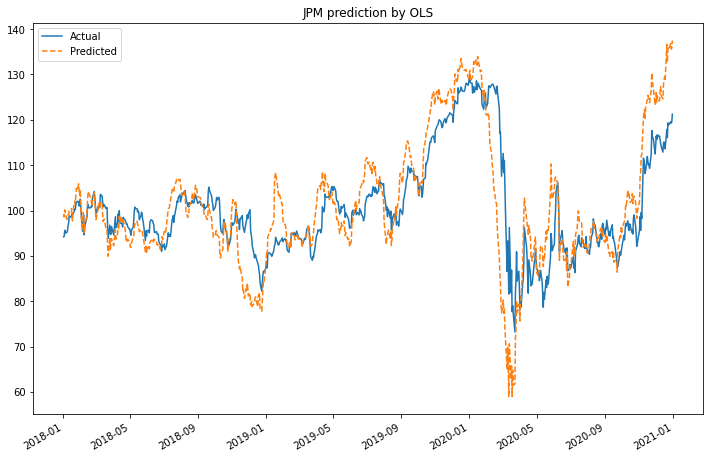

In [6]:
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')
class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        df.sort_index(inplace=True)
        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]
    
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                       end_date='2020', lookback_period=20)

%matplotlib inline

linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));                


Risk Metrics for measuring the prediction performance

In [7]:
#Mean absolute error as a risk metric

from sklearn.metrics import mean_absolute_error

actual = linear_reg_model.df_result['Actual']
predicted = linear_reg_model.df_result['Predicted']

mae = mean_absolute_error(actual, predicted)
print('mean absolute error:', mae)

#Mean Square Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predicted)
print('mean squared error:', mse)

#Explained variance score
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

#R^2 as a risk metric
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted) 
print('r2 score:', r2)


mean absolute error: 5.437268936426536
mean squared error: 60.68560694895708
explained variance score: 0.4874100582310119
r2 score: 0.483836586863407


In [17]:
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, 
    explained_variance_score, r2_score
)
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))    

Ridge Regression Model

<AxesSubplot:title={'center':'JPM prediction by Ridge Regreesion'}>

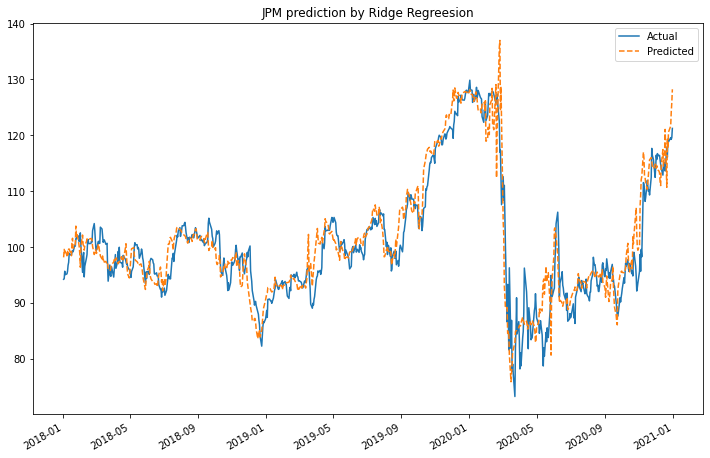

In [9]:
from sklearn.linear_model import Ridge

class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2020', lookback_period=20)

%matplotlib inline
ridge_reg_model.df_result.plot(
    title='JPM prediction by Ridge Regreesion', 
    style=['-', '--'], figsize=(12,8))

In [18]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 2.84261756583772
mean_squared_error: 16.01709399765301
explained_variance_score: 0.8668595202662702
r2_score: 0.8637660835573089


Predicting Returns with a cross-asset momentum model

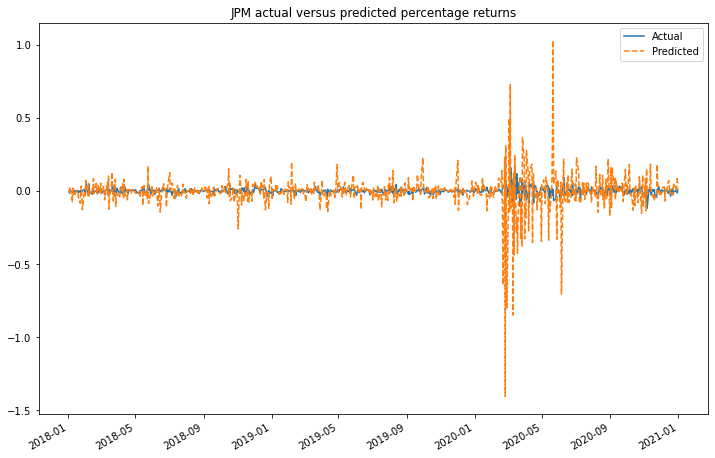

In [19]:
df_gld, meta_data = ts.get_daily_adjusted(
    symbol='GLD', outputsize='full')
df_dxy, dxy_meta_data = ts.get_daily_adjusted(
    symbol='UUP', outputsize='full')
df_ief, meta_data = ts.get_daily_adjusted(
    symbol='IEF', outputsize='full')


import pandas as pd

df_assets = pd.DataFrame({
    'GLD': df_gld['5. adjusted close'],
    'UUP': df_dxy['5. adjusted close'],
    'IEF': df_ief['5. adjusted close'],
}).dropna()

df_assets_1m = df_assets.pct_change(periods=20)
df_assets_1m.columns = ['%s_1m'%col for col in df_assets.columns]

df_assets_3m = df_assets.pct_change(periods=60)
df_assets_3m.columns = ['%s_3m'%col for col in df_assets.columns]

df_assets_6m = df_assets.pct_change(periods=120)
df_assets_6m.columns = ['%s_6m'%col for col in df_assets.columns]

df_assets_12m = df_assets.pct_change(periods=240)
df_assets_12m.columns = ['%s_12m'%col for col in df_assets.columns]

df_lagged = df_assets_1m.join(df_assets_3m)\
    .join(df_assets_6m)\
    .join(df_assets_12m)\
    .dropna()

y = jpm_prices.pct_change().dropna()

multi_linear_model = LinearRegressionModel()
multi_linear_model.learn(df_lagged, y, start_date='2018', 
                         end_date='2020', lookback_period=10)

multi_linear_model.df_result.plot(
    title='JPM actual versus predicted percentage returns',
    style=['-', '--'], figsize=(12,8));

In [20]:
print_regression_metrics(multi_linear_model.df_result)

mean_absolute_error: 0.058240696541704225
mean_squared_error: 0.01449869049445213
explained_variance_score: -27.765774762645364
r2_score: -27.832568547234132


Bagging Regressor Model

mean_absolute_error: 0.016309127484708783
mean_squared_error: 0.0006665170713265346
explained_variance_score: -0.32518357998047387
r2_score: -0.3254575752394684


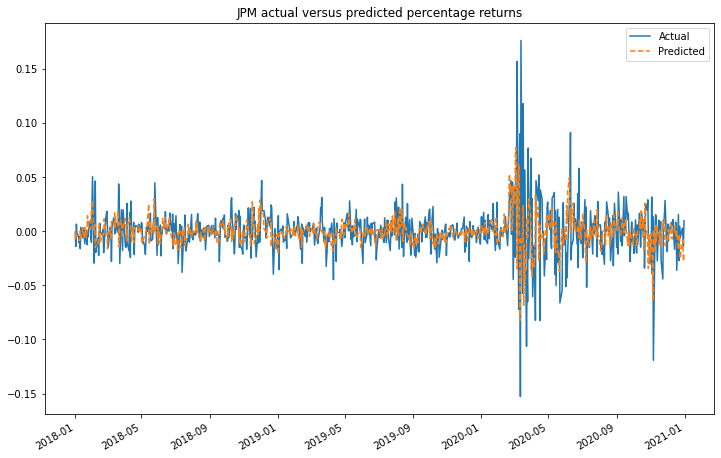

In [21]:
from sklearn.ensemble import BaggingRegressor

class BaggingRegressorModel(LinearRegressionModel):
    def get_model(self):
        return BaggingRegressor(n_estimators=20, random_state=0)  

bagging = BaggingRegressorModel()
bagging.learn(df_lagged, y, start_date='2018', 
              end_date='2020', lookback_period=10)

bagging.df_result.plot(
    title='JPM actual versus predicted percentage returns',
    style=['-', '--'], figsize=(12,8));

print_regression_metrics(bagging.df_result)

Prediciting Trends with classification-based machine learning

In [22]:
df_input = df_assets_1m.join(df_assets_3m).dropna()

Logistic Regression

In [26]:
import numpy as np
y_direction = y >= 0

from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression(solver='lbfgs')


logistic_reg_model = LogisticRegressionModel()
logistic_reg_model.learn(df_input, y_direction, start_date='2018', 
                         end_date='2020', lookback_period=100)


logistic_reg_model.df_result.head()

,Actual,Predicted
2018-01-02,False,False
2018-01-03,False,False
2018-01-04,True,False
2018-01-05,False,False
2018-01-08,False,False
